# Tensor factorization

With help from:

https://medium.com/yadb/tensor-factorization-for-graph-analysis-in-python-590df44c9f6c

In [1]:
import tensorly as tl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
# Open bike trips data
df_bike_trips = pd.read_csv("Edinburgh/bike_trips/df_bike_trips.csv")
df_bike_trips.started_at = pd.to_datetime(df_bike_trips.started_at)
df_bike_trips.ended_at = pd.to_datetime(df_bike_trips.ended_at)
df_bike_trips['trip_duration'] = (df_bike_trips.ended_at-df_bike_trips.started_at).apply(lambda x : x.seconds/60)

In [3]:
import geopandas as gpd
from shapely.geometry import Point

# Extract the bike stations in it

def get_all_stations(df):
    df_start_stations = df[['start_station_id','start_station_name', 'start_station_latitude', 'start_station_longitude']]
    df_end_stations = df[['end_station_id','end_station_name','end_station_latitude','end_station_longitude']]
    df_start_stations.columns = ['station_id', 'station_name', 'station_lat', 'station_lon']
    df_end_stations.columns = ['station_id', 'station_name', 'station_lat', 'station_lon']
    return df_start_stations.append(df_end_stations).drop_duplicates().set_index('station_id')

df_stations = get_all_stations(df_bike_trips)
df_stations.to_csv('df_stations.csv')
df_stations['geometry'] = df_stations[['station_lat','station_lon']].apply(lambda x : Point(*x), axis=1)
df_stations=gpd.GeoDataFrame(df_stations)

In [4]:
from pyproj import CRS

df_stations.crs = CRS.from_epsg(4326)

In [5]:
df_trips = df_bike_trips[['started_at', 'ended_at', 'trip_duration', 'start_station_id', 'end_station_id']].copy()

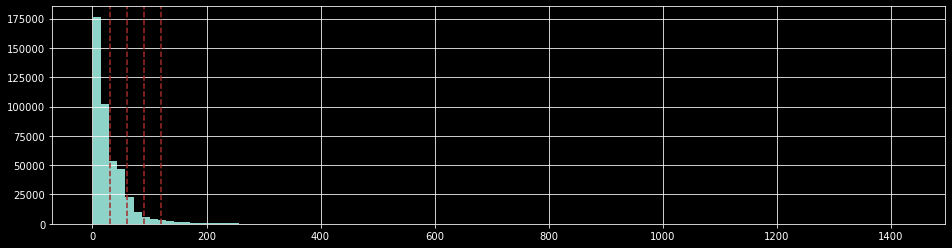

In [6]:
df_trips.trip_duration.hist(bins=100, figsize=(16,4))
plt.axvline(30, color='brown', ls='--')
plt.axvline(60, color='brown', ls='--')
plt.axvline(90, color='brown', ls='--')
plt.axvline(120, color='brown', ls='--')

In [7]:
df_trips.trip_duration.describe()

count    436420.000000
mean         31.906282
std          40.986529
min           1.016667
25%          10.400000
50%          19.383333
75%          42.133333
max        1423.883333
Name: trip_duration, dtype: float64

In [8]:
# Interesting how removing self loops greatly reduces the average length of trip;
# Most self-loops seem to correspond to longer rides. IN which stations do they occur most often?
# We have to get rid of them because we can't map them, we have no info on the route that people took for their loop. 
df_trips = df_trips[df_trips.start_station_id!=df_trips.end_station_id]
df_trips.trip_duration.describe()

count    371577.000000
mean         28.017167
std          36.709375
min           1.016667
25%           9.966667
50%          17.300000
75%          35.433333
max        1423.883333
Name: trip_duration, dtype: float64

In [9]:
# Some stations are only in there as end stations, and some only as start stations.
# Statistically it's weird, but also it messes up with data alignment; better get rid of them altogether
# (there's only 3 of them)

end_stations = df_trips.end_station_id.unique()
df_trips= df_trips[df_trips.start_station_id.isin(end_stations)]

start_stations = df_trips.start_station_id.unique()
df_trips = df_trips[df_trips.end_station_id.isin(start_stations)]

station_to_ix = {j:i for i,j in enumerate(sorted(df_trips.start_station_id.unique()))}
ix_to_station = {j:i for i,j in station_to_ix.items()}

df_trips[['start_station_id', 'end_station_id']] = df_trips[['start_station_id', 'end_station_id']].applymap(lambda x : station_to_ix[x])
df_trips['started_floor'] = df_trips.started_at.apply(lambda x:x.floor('15min'))
df_trips['ended_floor'] = df_trips.ended_at.apply(lambda x:x.floor('15min'))

df_trips['weekday'] = df_trips.started_at.apply(lambda x:x.weekday)
df_trips['hour'] = df_trips.started_at.apply(lambda x:x.hour)
df_trips['trip']=1

### Let's try a factorization per hour of the day, to start. 

In [10]:
def get_tensor_old(df):
    """
    Old inefficient way of filling the tensor
    """
    T = np.zeros((len(df.start_station_id.unique()), len(df.end_station_id.unique()), 24), dtype=float)

    for row in df[['hour', 'start_station_id', 'end_station_id']].iterrows():
        T[row[1]['start_station_id'],row[1]['end_station_id'],row[1]['hour']]+=1
    
    return T

def get_tensor(df_trips):
    T = np.zeros((len(df_trips.start_station_id.unique()), len(df_trips.end_station_id.unique()), 24), dtype=float)

    n_trips = df_trips.groupby(['start_station_id', 'end_station_id', 'hour']).trip.sum()

    for t in n_trips.items():
        ix = t[0]
        val = t[1]
        T[ix]=val

    return T

def factorization(T, R):

    F=NNP(tensor=T, rank=R, verbose=0)
    weights=F[0]
    factors=F[1]
    Us,Vs,Xs = factors
    
    return Us,Vs,Xs

In [11]:
T=get_tensor(df_trips)

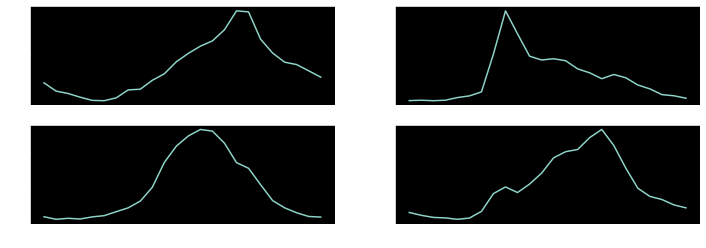

In [12]:
from tensorly.decomposition import non_negative_parafac as NNP

R=4

est_T=NNP(tensor=T, rank=R, verbose=0)

weights=est_T[0]
factors=est_T[1]

Us,Vs,Xs = factors

fig, axes = plt.subplots(2,2, figsize=(12,4))
fig.patch.set_alpha(0)
axes=axes.flatten()

for i in range(R):

    starts = Us[:, i]
    ends = Vs[:, i]
    t_intensity = Xs[:, i]

    axes[i].plot(t_intensity)

plt.show()

### Let's try the core consistency .

C is a negative sum of the reconstruction error. <br>
It is $~ (1 - \frac{\sum \epsilon }{n}$, with $\epsilon$ the reconstruction error (Identity matrix - actual superdiag matrix needed to rebuild T from the factors) : Higher reconstruction error means high |CC| in the negative: we want to maximize both k and CC !

In [18]:
import gc
from sktensor import dtensor, cp_als
import imp
import corcondia
imp.reload(corcondia)

<module 'corcondia' from 'D:\\Science\\data_science\\Bike_Share_data\\corcondia.py'>

In [19]:
def get_CC(T, R, debug=False):
    
    Us, Vs, Xs = factorization(T, R)
    
    est_T = np.zeros(T.shape)
    for u,v,x in zip(Us.T, Vs.T, Xs.T):
        est_T+=np.outer(np.outer(u, v), x).reshape(est_T.shape)
    
    
    CC=corcondia.corcondia_2(dtensor(est_T), Us,Vs,Xs, components = R)
    
    del est_T, Us, Vs, Xs
    gc.collect()
    
    if debug: print(R, CC, pd.Timestamp.now())
    return CC

In [20]:
mean_CC = lambda x, y=False : np.mean([get_CC(T, R=x, debug=y) for i in range(2)])

1 100 2021-06-26 18:58:27.960770
1 100 2021-06-26 18:58:28.086616
4 100 2021-06-26 18:58:31.066049
4 100 2021-06-26 18:58:33.835047
7 100 2021-06-26 18:58:38.462524
7 100 2021-06-26 18:58:43.131210
10 100 2021-06-26 18:58:49.701801
10 100 2021-06-26 18:58:56.280988


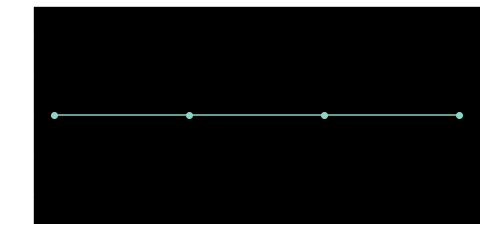

In [21]:
fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
x_range = range(1, 13, 3)
plt.plot(x_range, [mean_CC(R, True) for R in x_range], marker='o')
plt.show()

In [32]:
mean_CC = lambda x, y=False : np.mean([get_CC(T, R=x, debug=y) for i in range(1)])

20 100 2021-06-26 19:18:59.758386
22 100 2021-06-26 19:19:14.310884
24 100 2021-06-26 19:19:29.826153
26 92 2021-06-26 19:22:11.824314
28 86 2021-06-26 19:23:24.724055
30 80 2021-06-26 19:24:39.989874
32 75 2021-06-26 19:26:00.634009
34 71 2021-06-26 19:27:18.538365


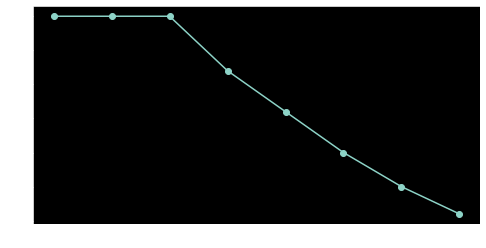

In [34]:
fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
x_range = range(20, 35, 2)
plt.plot(x_range, [mean_CC(R, True) for R in x_range], marker='o')
plt.show()

# Map a parallel factor back to the bike stations

In [36]:
Us[:, 0]

array([1.87948453e+002, 1.17607379e+002, 1.20441049e+002, 3.54383816e+001,
       6.40251571e+001, 8.76969179e+001, 3.16579435e+002, 1.55501781e+002,
       1.28147287e+001, 6.91433215e+000, 7.52346537e+001, 1.82311522e+002,
       1.72439868e+002, 1.40673722e+001, 4.40784336e+001, 2.59074210e+001,
       7.94973372e+000, 9.13062726e+001, 1.87178721e+002, 4.72631012e+000,
       1.12015457e-008, 8.27465151e+001, 2.30936549e+002, 2.20173143e-002,
       1.45603585e-007, 1.85073408e-001, 2.01478940e+001, 2.11539787e-003,
       1.81381125e-001, 3.57997366e+000, 1.28327248e+002, 6.88845262e+001,
       9.55650831e+001, 6.31183183e-002, 6.81676300e-002, 3.33197040e+001,
       2.03531218e+001, 4.89041494e+000, 3.37673486e+000, 1.57396841e+001,
       2.25738237e+001, 1.04497631e+001, 1.54009053e+001, 1.07742885e+001,
       2.98989181e+000, 3.35098563e+000, 2.74356148e+001, 1.21165771e+000,
       8.09998064e-013, 2.45860222e+000, 2.08886094e+000, 3.74037338e+000,
       1.21954072e+000, 6

In [ ]:
R=24

T = get_tensor(df_trips)
Us,Vs,Xs = factorization(T, R)


In [54]:
for nth_factor in range(R):

    factor_trips = pd.DataFrame(columns=['start', 'end', 'intensity'], index=range(len(Us[:, nth_factor])**2))
    factor = np.outer(Us[:, nth_factor], Vs[:, nth_factor])
    factor_trips.intensity = factor.flatten()
    factor_trips.start = factor_trips.index//len(Us[:, 0])
    factor_trips.end = factor_trips.index%len(Us[:, 0])
    
    factor_trips['start_station_id'] = factor_trips.start.apply(lambda x : ix_to_station[x])
    factor_trips['end_station_id'] = factor_trips.end.apply(lambda x : ix_to_station[x])

    factor_trips.to_csv(f'Factors/factor_trips_{nth_factor}.csv')
    
    pd.DataFrame(Xs[:, nth_factor], columns = ['H_intensity']).to_csv(f'Factors/Factor_temporality_{nth_factor}.csv')
    print(nth_factor, 'th factor stored !', pd.Timestamp.now())

0 th factor stored ! 2021-06-26 19:39:04.443218
1 th factor stored ! 2021-06-26 19:39:04.690584
2 th factor stored ! 2021-06-26 19:39:04.913235
3 th factor stored ! 2021-06-26 19:39:05.192023
4 th factor stored ! 2021-06-26 19:39:05.414304
5 th factor stored ! 2021-06-26 19:39:05.661822
6 th factor stored ! 2021-06-26 19:39:05.878059
7 th factor stored ! 2021-06-26 19:39:06.109921
8 th factor stored ! 2021-06-26 19:39:06.348372
9 th factor stored ! 2021-06-26 19:39:06.564540
10 th factor stored ! 2021-06-26 19:39:06.818721
11 th factor stored ! 2021-06-26 19:39:07.066193
12 th factor stored ! 2021-06-26 19:39:07.282317
13 th factor stored ! 2021-06-26 19:39:07.520675
14 th factor stored ! 2021-06-26 19:39:07.799373
15 th factor stored ! 2021-06-26 19:39:08.037845
16 th factor stored ! 2021-06-26 19:39:08.623495
17 th factor stored ! 2021-06-26 19:39:08.886624
18 th factor stored ! 2021-06-26 19:39:09.203280
19 th factor stored ! 2021-06-26 19:39:09.472629
20 th factor stored ! 2021-06-

further ideas:
- week vs weekend
- weekdays
- absolute bicycle flow vs differential bicycle flow 